# The Effect of Municipal Permitting on Local Housing Markets

## Introduction


I am using the **Fannie Mae and Freddie Mac** data. I'm interested to look at the lending data as a proxy for housing sales, and to analyze either the effects of municipal permitting on housing markets on a MSA-to-MSA level, or look at how the ownership structure of housing differs between "high opportunity" and "low opportunity" areas.

## Data Loading

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, significant data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and then combine the Freddie and Fannie data into one dataframe for the year.

In [24]:
cols = ["flag","record_no","postal_code","msa_code","cty_code", "tract","pct_minority","median_inc_tract","ami","tract_inc_ratio","amfi","upb","purpose","seller_type","guarantee","lien_status","LTV","date","term_at_org","num_of_units","int_rate","note_amt","prop_val","pre_pen","balloon","26","27","28","29","30","31","32","33","34","35","36","37"]
freddie_2023 = pd.read_csv('data/fhlmc_mf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
fannie_2023 = pd.read_csv('data/fnma_mf2023c_loans.txt', sep=r'\s+', header=None, names = cols)
loans_2023 = pd.concat([freddie_2023, fannie_2023])
# msa_codes = pd.read_csv('data/MSA_2023.txt', sep=r'\s+', header=None, names = ["msa_code","msa_name"])
# msa_codes

## Summary Statistics

One potentially interesting summary statistic is the quantity of loans in 2023 in each metropolitan area. We use ``groupby`` to look at each individual MSA and the count of entries in the table for each to define ``vol_by_msa`` which is the loan volume in each MSA.

In [20]:
vol_by_msa = loans_2023.groupby('msa_code').size().sort_values(ascending=False)

## Plots \& Figures

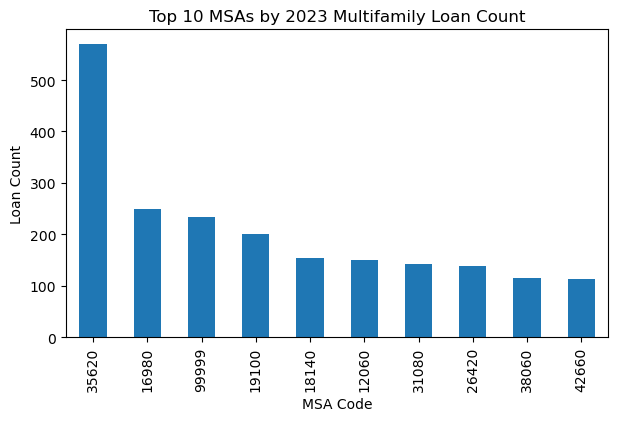

In [23]:
vol_by_msa.head(10).plot(kind='bar', figsize=(7, 4))
plt.title('Top 10 MSAs by 2023 Multifamily Loan Count')
plt.xlabel('MSA Code')
plt.ylabel('Loan Count')
plt.show()

## Conclusion